* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import tqdm

In [3]:
# These paths are hardcoded for my system, change as needed.

image_size = 96
tokens_dataset_folder = f'b={image_size}_d=2011,2012,2013_c=all_t=2'

prefix = os.path.join(os.getcwd(), 'data', 'tokens', tokens_dataset_folder)

train_path = os.path.join(prefix, 'train', 'train.pickle')
test_path = os.path.join(prefix, 'test', 'test.pickle')
classes_path = os.path.join(prefix, 'classes.txt')

In [4]:
def encode_ohe(class_name, classes):
    one_hot = np.zeros(shape=(len(classes)), dtype=np.int8)
    class_index = classes.index(class_name)
    one_hot[class_index] = 1

    return one_hot

def decode_ohe(one_hot, classes):
    index = one_hot.argmax()
    return classes[index]

After unpickling, `train_set` and `test_set` will be lists, where each element is a dictionary that has keys `features` and `labels`. `features` will be a 1D numpy array of 1's and 0's, with size `box_size * box_size` where `box_size` is the size of the image. `label` will be a one-hot-encoded array.

In [5]:
class MathTokensDataset(Dataset):
    """
    Dataset containing math tokens extracted from the CROHME 2011, 2012, and 2013 datasets.
    """
    
    def __init__(self, pickle_file, image_size, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
        
        # Reshape features to 3D tensor.
        self.df_data['features'] = self.df_data['features'].apply(lambda vec: vec.reshape(1, image_size, image_size))
        
        # Convert one-hot labels to numbers (PyTorch expects this).
        self.df_data['label'] = self.df_data['label'].apply(lambda ohe_vec: np.argmax(ohe_vec))

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {
            'features': self.df_data.iloc[idx]['features'],
            'label': self.df_data.iloc[idx]['label']
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class BaselineTokenCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineTokenCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 9 * 9, 600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, num_classes)
        
    def forward(self, x):
        x = x.float()
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
train_set = MathTokensDataset(train_path, image_size)
test_set = MathTokensDataset(test_path, image_size)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

classes = np.array(open(classes_path, 'r').read().split())

In [8]:
print(f'{len(train_set)} training examples.')
print(f'{len(test_set)} test examples.')
print(f'{len(classes)} classes.')

78590 training examples.
8289 test examples.
101 classes.


In [9]:
# Set device to GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
num_epochs = 10

net = BaselineTokenCNN(num_classes=len(classes))
net.to(device)  # Send to GPU.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss_history = []

for epoch in tqdm(range(num_epochs), position=1):
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), position=0):
        # Get the inputs and send to GPU if available.
        features = data['features'].to(device)
        labels = data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save statistics
        
        train_loss_history.append(loss.item())
        
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

print('Finished Training')



Finished Training


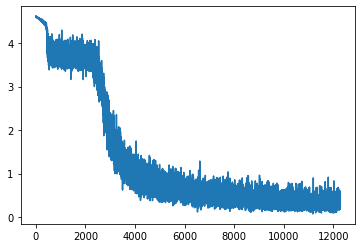

In [11]:
plt.plot(train_loss_history)

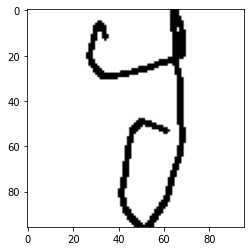

Predicted = y, Actual = y


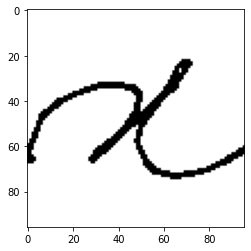

Predicted = x, Actual = x


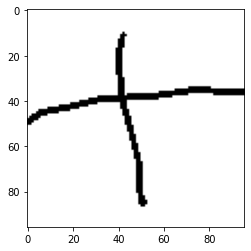

Predicted = +, Actual = +


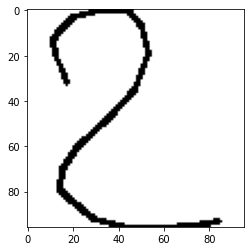

Predicted = 2, Actual = 2


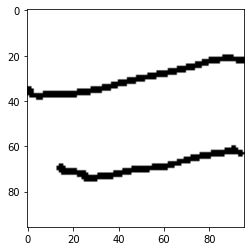

Predicted = =, Actual = =


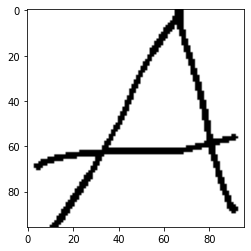

Predicted = A, Actual = A


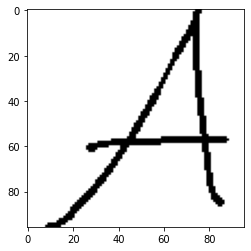

Predicted = A, Actual = A


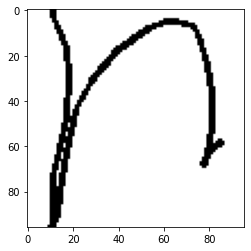

Predicted = n, Actual = n


In [12]:
test_data_iter = iter(test_loader)
data = test_data_iter.next()

test_features = data['features'].to(device)
labels = data['label'].to(device)

outputs = net(test_features)

# Tbh I'm not sure why it's max here and not argmax.
_, predicted = torch.max(outputs.data, dim=1)

for f, l, p, in zip(test_features, labels, predicted):
    f = np.squeeze(f.cpu().numpy())
    plt.figure()
    plt.imshow(f, cmap='gray')
    plt.show()
    print(f'Predicted = {classes[p]}, Actual = {classes[l]}')

In [13]:
# Compute accuracy on the test dataset.

# TODO: Compute the per-label accuracies.
# TODO: Keep track of mispredicted classes and randomly display a few.

num_classes = len(classes)

total_counts = np.zeros(num_classes)
correct_counts = np.zeros(num_classes)

num_correct = 0
num_total_examples = 0

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_features = test_data['features'].to(device)
        labels = test_data['label'].to(device)
        
        outputs = net(test_features)
        
        _, predicted = torch.max(outputs.data, dim=1)
        
        for p, l in zip(labels, predicted):
            total_counts[l] += 1
            if p == l:
                correct_counts[p] += 1
        
        num_total_examples += labels.size(0)
        num_correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on test set: {num_correct / num_total_examples * 100}%')


Accuracy of the network on test set: 84.509591024249%


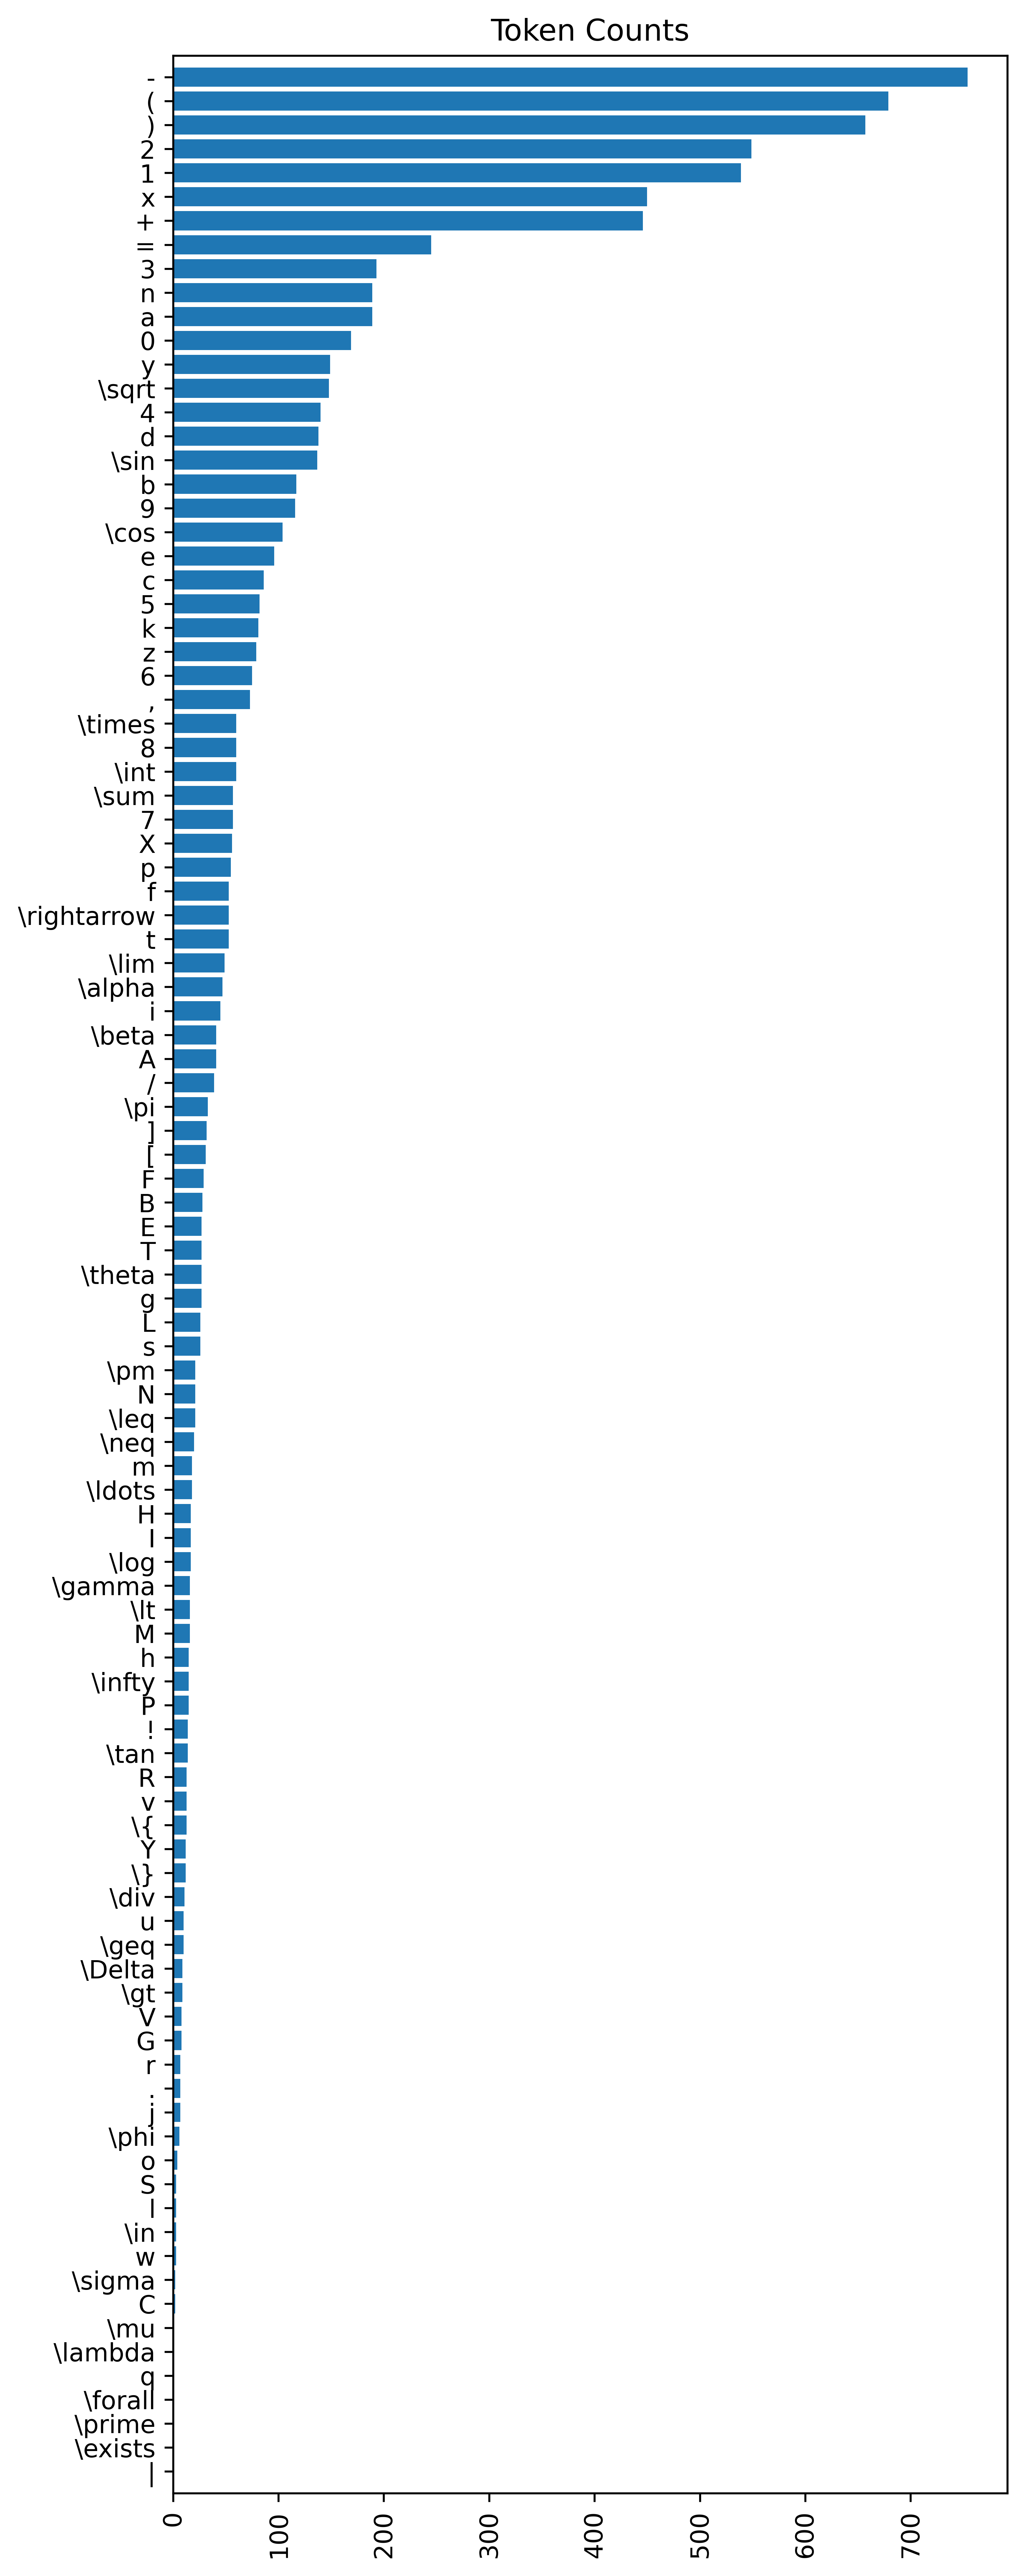

In [14]:
total_counts_idx = np.argsort(total_counts)
total_counts_idx = total_counts_idx.astype(int)

plt.figure(figsize=(6,18), dpi=600)
plt.barh(classes[total_counts_idx], total_counts[total_counts_idx])
plt.title('Token Counts')
plt.xticks(rotation=90)
plt.margins(y=0.005)
plt.show()

c:\users\jamin chen\development\10617_project\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


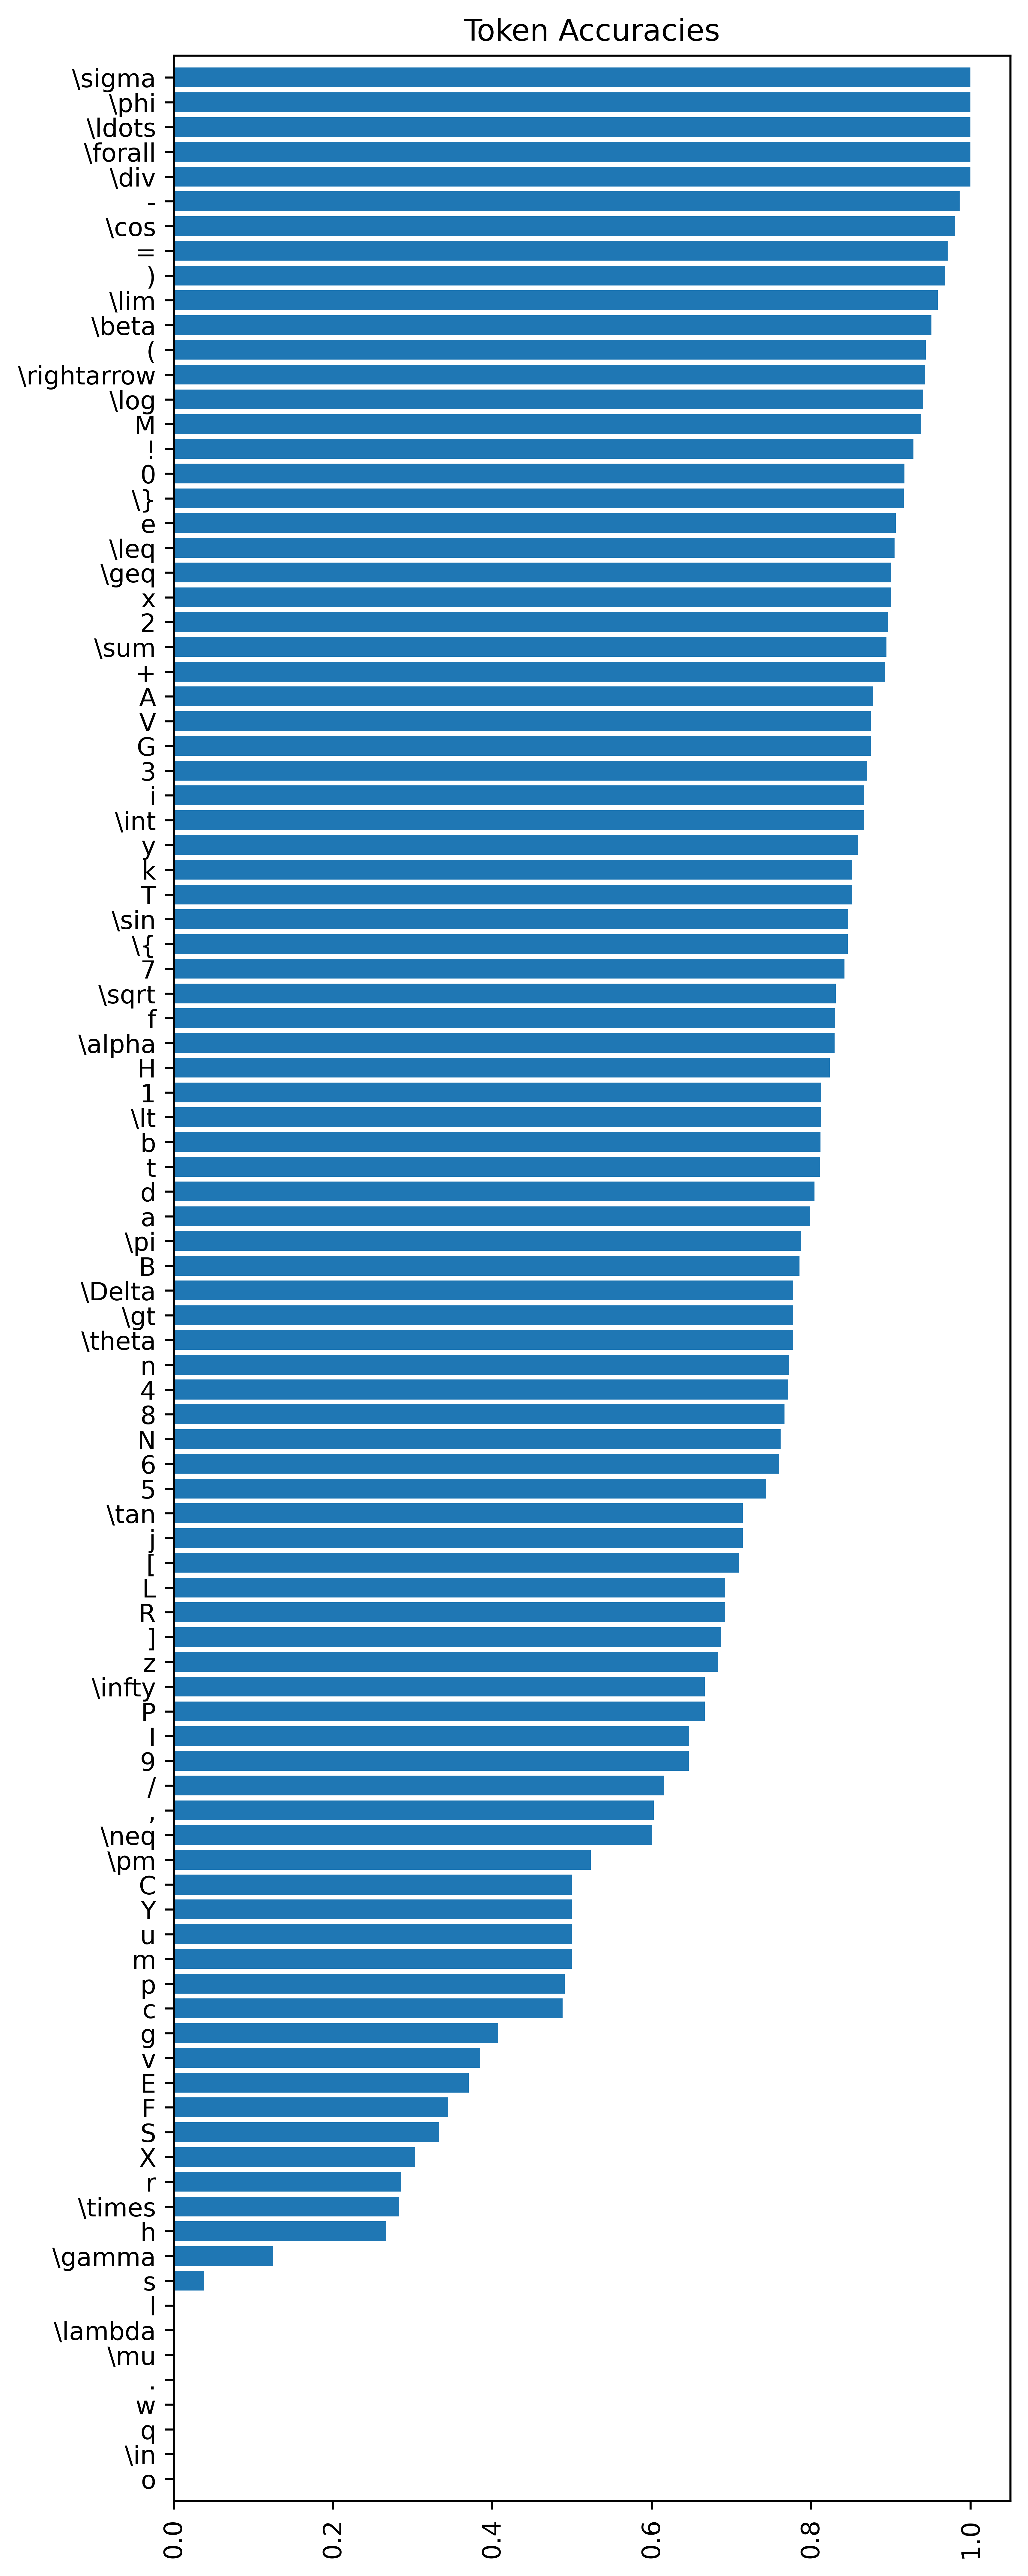

In [15]:
total_acc = correct_counts / total_counts

total_acc_idx = np.argsort(total_acc)
# total_acc_idx = total_acc_idx.astype(int)

plt.figure(figsize=(6,18), dpi=600)
plt.barh(classes[total_acc_idx], total_acc[total_acc_idx])
plt.title('Token Accuracies')
plt.xticks(rotation=90)
plt.margins(y=0.005)
plt.show()

# Identifying Expressions

In [16]:
import cv2

cv2.startWindowThread()

class ExpressionImageDataset(Dataset):
    """
    An expression-level dataset.
    """
    def __init__(self, pickle_file, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df_data.iloc[idx]
        
        img_path = row['img_path']
        tokens = row['tokens']
        latex = row['latex']
        
        # CV2 will read the image with white being 255 and black being 0, but since
        # our token-level training set uses binary arrays to represent images, we
        # need to binarize our image here as well.
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_binarized = cv2.threshold(image_raw, 127, 255, cv2.THRESH_BINARY)[1]
        image_bitmap = image_binarized / 255.0
        
        sample = {
            'image': image_binarized,
            'image_bitmap': image_bitmap,
            'tokens': tokens,
            'latex': latex
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
train_exp_path = os.path.join(os.getcwd(), 'data', 'all_years', 'train', 'train.pickle')
test_exp_path = os.path.join(os.getcwd(), 'data', 'all_years', 'test', 'test.pickle')

train_exp_set = ExpressionImageDataset(train_exp_path)
test_exp_set = ExpressionImageDataset(test_exp_path)

In [18]:
def image_to_components(img):
    # Invert the image because for CV2, foreground objects should be white, and the background black.
    img_flipped = cv2.bitwise_not(img)

    # cv2.connectedComponents returns a mask of the input where each element is a number from 0
    # to num_labels. All the 0's are considered the same component, 1's together, so on and
    # so forth.
    num_labels, labeled_img = cv2.connectedComponents(img_flipped)

    components = []

    # Skip the first component because it will be the background.
    for l in range(1, num_labels):
        mask = np.zeros(labeled_img.shape, dtype=np.uint8)
        mask[labeled_img == l] = 255

        rect = cv2.boundingRect(mask)

    #     # Draw bounding box to make sure it's correct.
    #     cv2.rectangle(mask, (x, y), (x + w, y + h), (36,255,12), 2)

        mask = cv2.bitwise_not(mask)

        components.append((mask, rect))

    components.sort(key=lambda c: (c[1][0], c[1][1]))

#     for mask, rect in components:    
#         plt.imshow(mask, cmap='gray')
#         plt.show()
        
    return components

In [19]:
def process_component(image, bounding_rect):
    x, y, w, h = bounding_rect
    
    # Crop the image to just the bounding box.
    image = image[y: y + h, x: x + w]
    
    # Pad the image so it's square.
    if w > h:
        pad = int((w - h) / 2)        
        image = cv2.copyMakeBorder(image, 
                                   top=pad, 
                                   bottom=pad, 
                                   left=0, 
                                   right=0, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    else:
        pad = int((h - w) / 2)
        image = cv2.copyMakeBorder(image, 
                                   top=0, 
                                   bottom=0, 
                                   left=pad, 
                                   right=pad, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    
    # Scale down to the correct size. Seems like cv2.INTER_AREA is the best
    # interpolation method for maintaining stroke wdith.
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    
    # During the resize some pixels will get scaled to be between 0 (black) and 255 (white).
    # In order to maintain stroke width, we set all non-white pixels to full black.
    # If we don't do this the resulting image ends up looking rather sparse.
    # We also convert the image to binary so that it's ready for the model.
    image = (image == 255).astype(int)
    
    return image

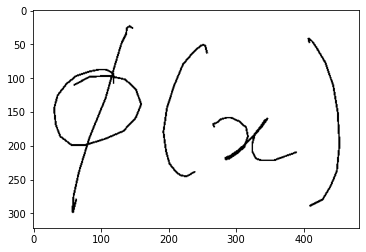

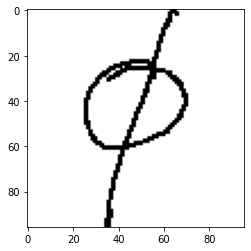

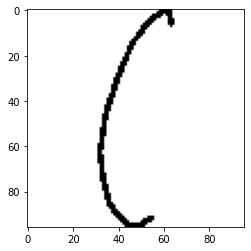

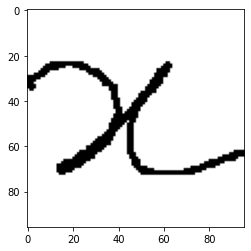

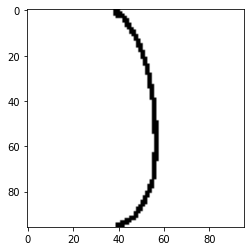

In [37]:
# Example code.
test_img = train_exp_set[0]['image']

plt.imshow(test_img, cmap='gray')
plt.show()

components = image_to_components(test_img)

for img, rect in components:
    out = process_component(img, rect)
    plt.imshow(out, cmap='gray')
    plt.show()

In [31]:
num_exp_correct = 0
num_tokens_wrong_dict = {}

for data in tqdm(train_exp_set):
    components = image_to_components(data['image'])
    
    all_components = [process_component(comp_img, comp_rect) for comp_img, comp_rect in components]
    
    features_numpy = np.array(all_components)
    features_numpy = np.expand_dims(features_numpy, 1)
    features_tensor = torch.from_numpy(features_numpy).to(device)
    
#     print(features_tensor.shape)
        
    outputs = net(features_tensor)
        
    _, predicted = torch.max(outputs.data, dim=1)
    
    predicted_tokens = classes[predicted.cpu()]
    actual_tokens = data['tokens']
    
    num_tokens_correct = 0
    for p, a in zip(predicted_tokens, actual_tokens):
        p = p.replace('\\', '')
        a = a.replace('\\', '')
        if p == a:
            num_tokens_correct += 1
            
    num_tokens_correct += np.max(len(actual_tokens) - len(predicted_tokens), 0)
    
#     print(f'Predicted tokens: {predicted_tokens}')
#     print(f'Actual tokens: {actual_tokens}')
    
    num_tokens_wrong = len(actual_tokens) - num_tokens_correct
    
    if num_tokens_wrong == 0:
        num_exp_correct += 1
        
    num_tokens_wrong_dict[num_tokens_wrong] = num_tokens_wrong_dict.get(num_tokens_wrong, 0) + 1

In [33]:
num_exp_correct

863

In [32]:
num_tokens_wrong_dict

{1: 762,
 4: 623,
 11: 244,
 16: 318,
 6: 521,
 18: 264,
 2: 595,
 7: 399,
 5: 538,
 12: 292,
 0: 863,
 15: 416,
 3: 640,
 17: 296,
 9: 333,
 20: 157,
 19: 246,
 8: 431,
 21: 125,
 10: 300,
 14: 288,
 26: 46,
 29: 21,
 13: 325,
 30: 20,
 25: 57,
 22: 106,
 36: 5,
 37: 6,
 23: 92,
 27: 26,
 28: 27,
 24: 67,
 32: 12,
 38: 3,
 31: 16,
 34: 10,
 39: 1,
 33: 8,
 35: 6,
 40: 3,
 42: 1,
 41: 1}

# Scratch

Below is some code I wrote to play around with drawing the traces from scratch.

In [ ]:
import cv2
from skimage.transform import resize

In [ ]:
train_exp_set[0]

In [ ]:
trace = train_exp_set[0]['traces_data'][0]


def get_trace_group_stats(trace_group):
    all_coords = []
    for t in trace_group:
        all_coords.extend(t)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height


def scale_trace_group(trace_group, image_size, width, height):
    scaling_factor = image_size / max(width, height)
    
    trace_group_scaled = [(trace * scaling_factor).astype(int) for trace in trace_group]
        
    return trace_group_scaled


def shift_trace_group(trace_group, x_min, y_min):
    trace_group_shifted = [trace - [x_min, y_min] for trace in trace_group]
    return trace_group_shifted


def draw_trace_group(trace_group, height, width, thickness):
    placeholder = np.ones((height, width))
        
    for trace in trace_group:
        for coord_idx in range(1, len(trace)):
            cv2.line(placeholder, tuple(trace[coord_idx - 1]), tuple(trace[coord_idx]), color=(0), thickness=thickness)
        
    return placeholder

    
def process_trace_group(trace_group, thickness=2):
    trace_group = [np.array(trace) for trace in trace_group]
    
    x_min, y_min, width, height = get_trace_group_stats(trace_group)
    
    trace_group = shift_trace_group(trace_group, x_min, y_min)
    trace_group = scale_trace_group(trace_group, image_size, width, height)
    
    im = draw_trace_group(trace_group, height=image_size, width=image_size, thickness=thickness)
    
#     new_im = cv2.copyMakeBorder(im, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=1)
    
#     im = cv2.resize(im, (image_size, image_size))
    
    
    
    plt.imshow(im, cmap='gray')
    
        
process_trace_group(trace['trace_group'])